<h2>About this Project</h2>
<p>In this project, you will implement a Classification and Regression Tree (CART) algorithm. You will work with the <a href="https://archive.ics.uci.edu/ml/datasets/Ionosphere">Ionosphere Data Set from the UCI Machine Learning Repository</a>, which consists of radar data from a system designed to target free electrons in the ionosphere. The data will be used to determine if a radar return was "good" (i.e. a signal was returned) or "bad" (i.e. the signal passed straight through the ionosphere). Your task will be to classify whether a return is good or bad based on the data.</p>

<h3>Evaluation</h3>

<p><strong>This project must be successfully completed and submitted in order to receive credit for this course. Your score on this project will be included in your final grade calculation.</strong><p>
    
<p>You are expected to write code where you see <em># YOUR CODE HERE</em> within the cells of this notebook. Not all cells will be graded; code input cells followed by cells marked with <em>#Autograder test cell</em> will be graded. Upon submitting your work, the code you write at these designated positions will be assessed using an "autograder" that will run all test cells to assess your code. You will receive feedback from the autograder that will identify any errors in your code. Use this feedback to improve your code if you need to resubmit. Be sure not to change the names of any provided functions, classes, or variables within the existing code cells, as this will interfere with the autograder. Also, remember to execute all code cells sequentially, not just those you’ve edited, to ensure your code runs properly.</p>
    
<p>You can resubmit your work as many times as necessary before the submission deadline. If you experience difficulty or have questions about this exercise, use the Q&A discussion board to engage with your peers or seek assistance from the instructor.<p>

<p>Before starting your work, please review <a href="https://s3.amazonaws.com/ecornell/global/eCornellPlagiarismPolicy.pdf">eCornell's policy regarding plagiarism</a> (the presentation of someone else's work as your own without source credit).</p>

<h3>Submit Code for Autograder Feedback</h3>

<p>Once you have completed your work on this notebook, you will submit your code for autograder review. Follow these steps:</p>

<ol>
  <li><strong>Save your notebook.</strong></li>
  <li><strong>Mark as Completed —</strong> In the blue menu bar along the top of this code exercise window, you’ll see a menu item called <strong>Education</strong>. In the <strong>Education</strong> menu, click <strong>Mark as Completed</strong> to submit your code for autograder/instructor review. This process will take a moment and a progress bar will show you the status of your submission.</li>
	<li><strong>Review your results —</strong> Once your work is marked as complete, the results of the autograder will automatically be presented in a new tab within the code exercise window. You can click on the assessment name in this feedback window to see more details regarding specific feedback/errors in your code submission.</li>
  <li><strong>Repeat, if necessary —</strong> The Jupyter notebook will always remain accessible in the first tabbed window of the exercise. To reattempt the work, you will first need to click <strong>Mark as Uncompleted</strong> in the <strong>Education</strong> menu and then proceed to make edits to the notebook. Once you are ready to resubmit, follow steps one through three. You can repeat this procedure as many times as necessary.</li>
</ol>

<p>You can also download a copy of this notebook in multiple formats using the <strong>Download as</strong> option in the <strong>File</strong> menu above.</p>

<h2>Implementing CART</h2>

### Getting Started

Before you get started, let's import a few packages that you will need. In addition, you will load two binary classification dataset - the spiral dataset and the <a href="https://archive.ics.uci.edu/ml/datasets/Ionosphere">ION</a> dataset. 

In [1]:
import numpy as np
from pylab import *
from numpy.matlib import repmat
import matplotlib 
import matplotlib.pyplot as plt
from scipy.io import loadmat
import time
import sys

%matplotlib notebook

sys.path.append('/home/codio/workspace/.guides/hf')
from helper import *

print('You\'re running python %s' % sys.version.split(' ')[0])

You're running python 3.6.8


The code below generates spiral data using the trigonometric functions sine and cosine, then splits the data into train and test segments.

In [2]:
def spiraldata(N=300):
    r = np.linspace(1,2*np.pi,N) # generate a vector of "radius" values
    xTr1 = np.array([np.sin(2.*r)*r, np.cos(2*r)*r]).T # generate a curve that draws circles with increasing radius
    xTr2 = np.array([np.sin(2.*r+np.pi)*r, np.cos(2*r+np.pi)*r]).T
    xTr = np.concatenate([xTr1, xTr2], axis=0)
    yTr = np.concatenate([np.ones(N), -1 * np.ones(N)])
    xTr = xTr + np.random.randn(xTr.shape[0], xTr.shape[1])*0.2
    
    # Now sample alternating values to generate the test and train sets.
    xTe = xTr[::2,:]
    yTe = yTr[::2]
    xTr = xTr[1::2,:]
    yTr = yTr[1::2]
    
    return xTr, yTr, xTe, yTe

xTrSpiral, yTrSpiral, xTeSpiral, yTeSpiral = spiraldata(150)

We can plot xTrSpiral to see the curve generated by the function above:

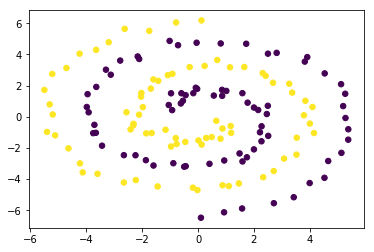

In [3]:
plt.scatter(xTrSpiral[:,0], xTrSpiral[:,1],30,yTrSpiral)

The following code loads the ION dataset.

In [4]:
# load in some binary test data (labels are -1, +1)
data = loadmat("ion.mat")

# Load the training data
xTrIon  = data['xTr'].T
yTrIon  = data['yTr'].flatten()

# Load the test data
xTeIon  = data['xTe'].T
yTeIon  = data['yTe'].flatten()

<h2> Implement Regression Trees </h2>


<h3> Part One: Implement <code>sqimpurity</code> [Graded]</h3>

<p>First, implement the function <code>sqimpurity</code> which takes as input a vector of $n$ labels and outputs the corresponding squared loss impurity
    $$\sum_{i} (y_i-\bar{y}_i)^2 \textrm{ where: } \bar{y}_i=\frac{1}{n}\sum_{i} y_i$$
</p>

In [5]:
def sqimpurity(yTr):
    """Computes the weighted variance of the labels
    
    Input:
        yTr:     n-dimensional vector of labels
    
    Output:
        impurity: weighted variance / squared loss impurity of this data set
    """
    
    N, = yTr.shape
    assert N > 0 # must have at least one sample
    impurity = 0
    
    # YOUR CODE HERE
    impurity = np.sum((yTr - 1 / N * np.sum(yTr))**2)
    
    return impurity

In [6]:
def sqimpurity_test1():
    yTr = np.random.randn(100) # generate random labels
    impurity = sqimpurity(yTr) # compute impurity
    return np.isscalar(impurity)  # impurity should be scalar

def sqimpurity_test2():
    yTr = np.random.randn(100) # generate random labels
    impurity = sqimpurity(yTr) # compute impurity
    return impurity >= 0 # impurity should be nonnegative

def sqimpurity_test3():
    yTr = np.ones(100) # generate an all one vector as labels
    impurity = sqimpurity(yTr) # compute impurity
    return np.isclose(impurity, 0) # impurity should be zero since the labels are homogeneous

def sqimpurity_test4():
    yTr = np.arange(-5, 6) # generate a vector with mean zero
    impurity = sqimpurity(yTr) # compute impurity
    sum_of_squares = np.sum(yTr ** 2) 
    return np.isclose(impurity, sum_of_squares) # with mean zero, then the impurity should be the sum of squares

def sqimpurity_test5():
    yTr = np.random.randn(100) # generate random labels
    impurity = sqimpurity(yTr)
    impurity_grader = sqimpurity_grader(yTr)
    return np.isclose(impurity, impurity_grader)

runtest(sqimpurity_test1, 'sqimpurity_test1')
runtest(sqimpurity_test2, 'sqimpurity_test2')
runtest(sqimpurity_test3, 'sqimpurity_test3')
runtest(sqimpurity_test4, 'sqimpurity_test4')
runtest(sqimpurity_test5, 'sqimpurity_test5')

Running Test: sqimpurity_test1 ... ✔ Passed!
Running Test: sqimpurity_test2 ... ✔ Passed!
Running Test: sqimpurity_test3 ... ✔ Passed!
Running Test: sqimpurity_test4 ... ✔ Passed!
Running Test: sqimpurity_test5 ... ✔ Passed!


In [7]:
# Autograder test cell - worth 1 Point
# runs sqimpurity_test1

In [8]:
# Autograder test cell - worth 1 Point
# runs sqimpurity_test2

In [9]:
# Autograder test cell - worth 1 Point
# runs sqimpurity_test3

In [10]:
# Autograder test cell - worth 1 Point
# runs sqimpurity_test4

In [11]:
# Autograder test cell - worth 1 Point
# runs sqimpurity_test5

<h3> Part Two: Implement <code>sqsplit</code> [Graded]</h3>

<p>Now implement <code>sqsplit</code>, which takes as input a data set with labels and computes the best feature and cut-value of an optimal split based on the squared error impurity. The <code>sqsplit</code> function takes as input a data set of row vectors and a label vector and outputs a feature dimension, a cut threshold, and the impurity loss of this best split. The cut value should be the average of the values in the dimension where two datapoints are split. To find the best split, evaluate all possible splits and then search for the split that yields the minimum loss.</p> 

<p>Remember that we evaluate the quality of a split of a parent set $S_P$ into two sets $S_L$ and $S_R$ by the weighted impurity of the two branches, i.e.</p>

$\frac{\left|S_L\right|}{\left|S_P\right|}I\left(S_L\right)+\frac{\left|S_R\right|}{\left|S_P\right|}I\left(S_R\right)$

<p>In the case of the squared loss, this becomes:</p>

$\frac{1}{|S_P|}\sum_{(x,y)\in S_L}(y-\bar{y}_{S_L})^2 +\frac{1}{|S_P|}\sum_{(x,y)\in S_R}(y-\bar{y}_{S_R})^2$

<em>Note: Avoid splitting on datapoints with same value in a dimension.</em> 

In [12]:
def sqsplit(xTr, yTr):
    """Finds the best feature, cut value, and loss value.
    
    Input:
        xTr:     n x d matrix of data points
        yTr:     n-dimensional vector of labels
    
    Output:
        feature:  index of the best cut's feature
        cut:      cut-value of the best cut
        bestloss: loss of the best cut
    """
    N,D = xTr.shape
    assert D > 0 # must have at least one dimension
    assert N > 1 # must have at least two samples
    
    bestloss = np.inf
    feature = np.inf
    cut = np.inf

    # YOUR CODE HERE
    for col in range(D):
        sort = xTr[:, col].argsort()
        sortx = xTr[sort, col]
        sorty = yTr[sort]
        
        for row in range(N):
            # if row + 1 exceeds range
            if row + 1 == N:
                continue
            # check where values change
            if sortx[row + 1] > sortx[row]:
                Sl = sorty[:row+1]
                Sr = sorty[row+1:]

                loss = sqimpurity(Sl) + sqimpurity(Sr)

                # if loss is smaller
                if loss < bestloss:
                    bestloss = loss
                    feature = col
                    cut = (sortx[row] + sortx[row + 1]) / 2
    
    return feature, cut, bestloss

In [13]:
# The tests below check that your sqsplit function returns the correct values for several different input datasets

t0 = time.time()
fid, cut, loss = sqsplit(xTrIon,yTrIon)
t1 = time.time()

print('Elapsed time: {:0.2f} seconds'.format(t1-t0))
print("The best split is on feature 2 on value 0.304")
print("Your tree split on feature %i on value: %2.3f \n" % (fid,cut))

def sqsplit_test1():
    a = np.isclose(sqsplit(xor4, yor4)[2] / len(yor4), .25)
    b = np.isclose(sqsplit(xor3, yor3)[2] / len(yor3), .25)
    c = np.isclose(sqsplit(xor2, yor2)[2] / len(yor2), .25)
    return a and b and c

def sqsplit_test2():
    x = np.array(range(1000)).reshape(-1,1)
    y = np.hstack([np.ones(500),-1*np.ones(500)]).T
    _, cut, _ = sqsplit(x, y)
    return cut <= 500 or cut >= 499

def sqsplit_test3():
    fid, cut, loss = sqsplit(xor5,yor5)
    # cut should be 0.5 but 0 is also accepted
    return fid == 0 and (cut >= 0 or cut <= 1) and np.isclose(loss / len(yor5), 2/3)

runtest(sqsplit_test1,'sqsplit_test1')
runtest(sqsplit_test2,'sqsplit_test2')
runtest(sqsplit_test3,'sqsplit_test3')

Elapsed time: 0.23 seconds
The best split is on feature 2 on value 0.304
Your tree split on feature 2 on value: 0.304 

Running Test: sqsplit_test1 ... ✔ Passed!
Running Test: sqsplit_test2 ... ✔ Passed!
Running Test: sqsplit_test3 ... ✔ Passed!


In [14]:
# Autograder test cell - worth 1 Point
# runs distance_accuracy

In [15]:
# Autograder test cell - worth 1 Point
# runs distance_accuracy

In [16]:
# Autograder test cell - worth 1 Point
# runs distance_accuracy

<h3> Part Three: Implement <code>cart</code> [Graded]</h3>

In this section, you will implement the function <code>cart</code>, which returns a regression tree based on the minimum squared loss splitting rule. You should use the function <code>sqsplit</code> to make your splits. <p>Use the provided <code>TreeNode</code> class below to represent your tree. Note that the nature of CART trees implies that every node has exactly 0 or 2 children.</p>

<h4>Tree Structure</h4>

<p>We've provided a tree structure for you with distinct leaves and nodes. Leaves have two fields, parent (another node) and prediction (a numerical value).</p>

<strong>Nodes have six fields:</strong>

<ol>
<li> <b>left</b>: node describing left subtree </li>
<li> <b>right</b>: node describing right subtree </li>
<li> <b>feature</b>: index of feature to cut </li>
<li> <b>cut</b>: cutoff value c (<=c : left, and >c : right)</li>
<li> <b>prediction</b>: prediction at this node </li>. This should be the average of the labels at this node.
</ol>

In [17]:
class TreeNode(object):
    """Tree class.
    (You don't need to add any methods or fields here but feel
    free to if you like. The tests will only reference the fields
    defined in the constructor below, so be sure to set these
    correctly.)
    """
    
    def __init__(self, left, right, feature, cut, prediction):
        self.left = left 
        self.right = right 
        self.feature = feature 
        self.cut = cut
        self.prediction = prediction 

The following cell contains some examples of trees.

In [18]:
# The following is a tree that predicts everything as zero ==> prediction 0
# In this case, it has no left or right children (it is a leaf node) ==> left = None, right = None
# The tree also do not split at any feature at any value ==> feature = None, cut = None, 
root = TreeNode(None, None, None, None, 0)


# The following that a tree with depth 2
# or a tree with one split 
# The tree will return a prediction of 1 if an example falls under the left subtree
# Otherwise it will return a prediction of 2
# To start, first create two leaf node
left_leaf = TreeNode(None, None, None, None, 1)
right_leaf = TreeNode(None, None, None, None, 2)

# Now create the parent or the root
# Suppose we split at feature 0 and cut of 1
# and the average prediction is 1.5
root2 = TreeNode(left_leaf, right_leaf, 0, 1 , 1.5)

# Now root2 is the tree we desired

In [19]:
def cart(xTr,yTr):
    """Builds a CART tree.
    
    The maximum tree depth is defined by "maxdepth" (maxdepth=2 means one split).
    Each example can be weighted with "weights".

    Args:
        xTr:      n x d matrix of data
        yTr:      n-dimensional vector

    Returns:
        tree: root of decision tree
    """
    n,d = xTr.shape
    
    # YOUR CODE HERE
    prediction = np.mean(yTr)
    indx = np.arange(n)
    
    #if node is leaf
    if np.all(yTr == yTr[0]) or np.max(np.abs(np.diff(xTr, axis=0))) < 1e-5:
        tree = TreeNode(None, None, None, None, prediction)
    
    else:
        
        feature, cut, loss = sqsplit(xTr, yTr)
          
        left_indx = indx[xTr[:,feature] <= cut]
        right_indx = indx[xTr[:,feature] > cut]
        left_xTr = xTr[left_indx,:]
        right_xTr = xTr[right_indx,:]
        left_yTr = yTr[left_indx]
        right_yTr = yTr[right_indx]
    
        left_node = cart(left_xTr,left_yTr)
        right_node = cart(right_xTr,right_yTr)
        parent_node = TreeNode(left_node, right_node, feature, cut, prediction)
        tree = TreeNode(left_node, right_node, feature, cut, prediction)  
    
    return tree

In [20]:
# The tests below check that your implementation of cart  returns the correct predicted values for a sample dataset

#test case 1
def cart_test1():
    t=cart(xor4,yor4)
    return DFSxor(t)

#test case 2
def cart_test2():
    y = np.random.rand(16);
    t = cart(xor4,y);
    yTe = DFSpreds(t)[:];
    # Check that every label appears exactly once in the tree
    y.sort()
    yTe.sort()
    return np.all(np.isclose(y, yTe))

#test case 3
def cart_test3():
    xRep = np.concatenate([xor2, xor2])
    yRep = np.concatenate([yor2, 1-yor2])
    t = cart(xRep, yRep)
    return DFSxorUnsplittable(t)

#test case 4
def cart_test4():
    X = np.ones((5, 2)) # Create a dataset with identical examples
    y = np.ones(5)
    
    # On this dataset, your cart algorithm should return a single leaf
    # node with prediction equal to 1
    t = cart(X, y)
    
    # t has no children
    children_check = (t.left is None) and (t.right is None) 
    
    # Make sure t does not cut any feature and at any value
    feature_check = (t.feature is None) and (t.cut is None)
    
    # Check t's prediction
    prediction_check = np.isclose(t.prediction, 1)
    return children_check and feature_check and prediction_check

#test case 5
def cart_test5():
    X = np.arange(4).reshape(-1, 1)
    y = np.array([0, 0, 1, 1])

    t = cart(X, y) # your cart algorithm should generate one split
    
    # check whether you set t.feature and t.cut to something
    return t.feature is not None and t.cut is not None



runtest(cart_test1,'cart_test1')
runtest(cart_test2,'cart_test2')
runtest(cart_test3,'cart_test3')
runtest(cart_test4,'cart_test4')
runtest(cart_test5,'cart_test5')

Running Test: cart_test1 ... ✔ Passed!
Running Test: cart_test2 ... ✔ Passed!
Running Test: cart_test3 ... ✔ Passed!
Running Test: cart_test4 ... ✔ Passed!
Running Test: cart_test5 ... ✔ Passed!


In [21]:
# Autograder test cell - worth 1 Point
# runs cart_test1

In [22]:
# Autograder test cell - worth 1 Point
# runs cart_test2

In [23]:
# Autograder test cell - worth 1 Point
# runs cart_test3

In [24]:
# Autograder test cell - worth 1 Point
# runs cart_test4

In [25]:
# Autograder test cell - worth 1 Point
# runs cart_test5

<h3> Part Four: Implement <code>evaltree</code> [Graded]</h3>

<p>Implement the function <code>evaltree</code>, which evaluates a decision tree on a given test data set.</p>

In [26]:
def evaltree(root,xTe):
    """Evaluates xTe using decision tree root.
    
    Input:
        root: TreeNode decision tree
        xTe:  n x d matrix of data points
    
    Output:
        pred: n-dimensional vector of predictions
    """
    # YOUR CODE HERE
    n,d = xTe.shape
    pred = np.zeros(n)

    for x in range(n):
        rt = root
        while(True):
            if rt.left is None or rt.right is None:
                pred[x] = rt.prediction
                break
            elif xTe[x,rt.feature] <= rt.cut:
                rt = rt.left
            else:
                rt = rt.right
                
    return pred

In [27]:
# The following tests check that your implementation of evaltree returns the correct predictions for two sample trees

t0 = time.time()
root = cart(xTrIon, yTrIon)
t1 = time.time()

tr_err   = np.mean((evaltree(root,xTrIon) - yTrIon)**2)
te_err   = np.mean((evaltree(root,xTeIon) - yTeIon)**2)

print("Elapsed time: %.2f seconds" % (t1-t0))
print("Training RMSE : %.2f" % tr_err)
print("Testing  RMSE : %.2f \n" % te_err)

#test case 1
def evaltree_test1():
    t = cart(xor4,yor4)
    xor4te = xor4 + (np.sign(xor4 - .5) * .1)
    inds = np.arange(16)
    np.random.shuffle(inds)
    # Check that shuffling and expanding the data doesn't affect the predictions
    return np.all(np.isclose(evaltree(t, xor4te[inds,:]), yor4[inds]))

#test case 2
def evaltree_test2():
    a = TreeNode(None, None, None, None, 1)
    b = TreeNode(None, None, None, None, -1)
    c = TreeNode(None, None, None, None, 0)
    d = TreeNode(None, None, None, None, -1)
    e = TreeNode(None, None, None, None, -1)
    x = TreeNode(a, b, 0, 10, 0)
    y = TreeNode(x, c, 0, 20, 0)
    z = TreeNode(d, e, 0, 40, 0)
    t = TreeNode(y, z, 0, 30, 0)
    # Check that the custom tree evaluates correctly
    return np.all(np.isclose(
            evaltree(t, np.array([[45, 35, 25, 15, 5]]).T),
            np.array([-1, -1, 0, -1, 1])))

runtest(evaltree_test1,'evaltree_test1')
runtest(evaltree_test2,'evaltree_test2')

Elapsed time: 0.99 seconds
Training RMSE : 0.00
Testing  RMSE : 0.69 

Running Test: evaltree_test1 ... ✔ Passed!
Running Test: evaltree_test2 ... ✔ Passed!


In [28]:
# Autograder test cell - worth 1 Point
# runs evaltree_test1

In [29]:
# Autograder test cell - worth 1 Point
# runs evaltree_test2

<h3> Visualize Your Tree</h3>

<p>The following code defines a function <code>visclassifier()</code>, which plots the decision boundary of a classifier in 2 dimensions. Execute the following code to see what the decision boundary of your tree looks like on the ion data set. </p>

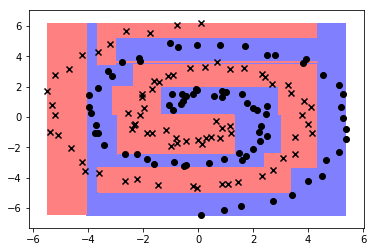

Training error: 0.0000
Testing error:  0.0067


In [30]:
def visclassifier(fun,xTr,yTr,w=None,b=0):
    """
    visualize decision boundary
    Define the symbols and colors we'll use in the plots later
    """

    yTr = np.array(yTr).flatten()
    

    symbols = ["ko","kx"]
    marker_symbols = ['o', 'x']
    mycolors = [[0.5, 0.5, 1], [1, 0.5, 0.5]]
    # get the unique values from labels array
    classvals = np.unique(yTr)

    plt.figure()

    # return 300 evenly spaced numbers over this interval
    res=300
    xrange = np.linspace(min(xTr[:, 0]), max(xTr[:, 0]),res)
    yrange = np.linspace(min(xTr[:, 1]), max(xTr[:, 1]),res)
    
    # repeat this matrix 300 times for both axes
    pixelX = repmat(xrange, res, 1)
    pixelY = repmat(yrange, res, 1).T

    
    xTe = np.array([pixelX.flatten(), pixelY.flatten()]).T

    # test all of these points on the grid
    testpreds = fun(xTe)
    
    # reshape it back together to make our grid
    Z = testpreds.reshape(res, res)
    # Z[0,0] = 1 # optional: scale the colors correctly
    
    # fill in the contours for these predictions
    plt.contourf(pixelX, pixelY, np.sign(Z), colors=mycolors)

    # creates x's and o's for training set
    for idx, c in enumerate(classvals):
        plt.scatter(xTr[yTr == c,0],
            xTr[yTr == c,1],
            marker=marker_symbols[idx],
            color='k'
            )
    
    if w is not None:
        w = np.array(w).flatten()
        alpha = -1 * b / (w ** 2).sum()
        plt.quiver(w[0] * alpha, w[1] * alpha,
            w[0], w[1], linewidth=2, color=[0,1,0])

    plt.axis('tight')
    # shows figure and blocks
    plt.show()

tree=cart(xTrSpiral,yTrSpiral) # compute tree on training data 
visclassifier(lambda X:evaltree(tree,X), xTrSpiral, yTrSpiral)
print("Training error: %.4f" % np.mean(np.sign(evaltree(tree,xTrSpiral)) != yTrSpiral))
print("Testing error:  %.4f" % np.mean(np.sign(evaltree(tree,xTeSpiral)) != yTeSpiral))

<IPython.core.display.Javascript object>


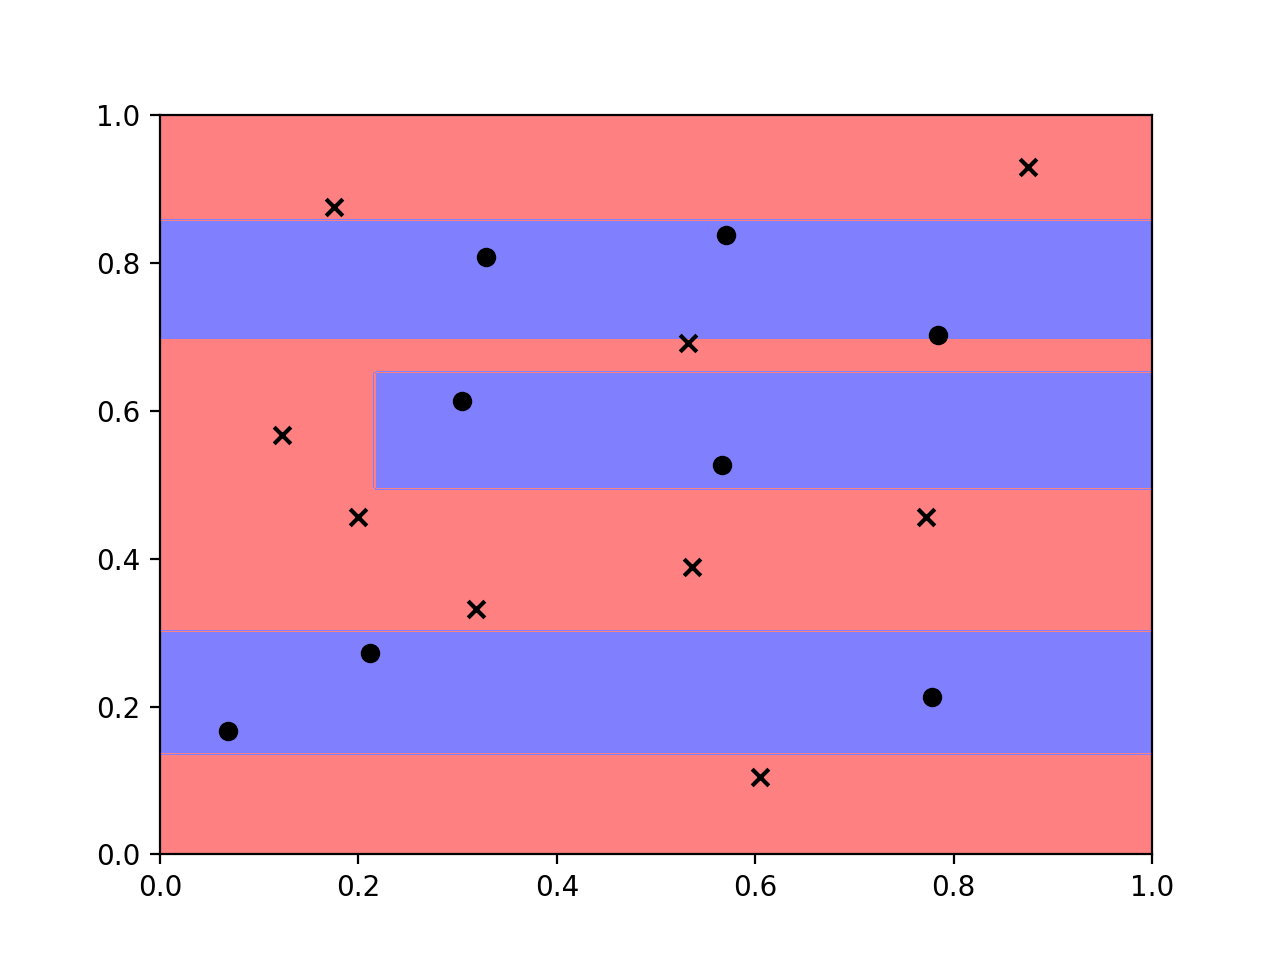

Text(0.5, 1.0, 'Click to add positive points and use shift-click to add negative points.')

In [31]:
def onclick_cart(event):
    """
    Visualize cart, including new point
    """
    global xTraining,labels
    # create position vector for new point
    pos=np.array([[event.xdata,event.ydata]]) 
    if event.key == 'shift': # add positive point
        color='or'
        label=1
    else: # add negative point
        color='ob'
        label=-1    
    xTraining = np.concatenate((xTraining,pos), axis = 0)
    labels.append(label);
    marker_symbols = ['o', 'x']
    classvals = np.unique(labels)
        
    mycolors = [[0.5, 0.5, 1], [1, 0.5, 0.5]]
    
    # return 300 evenly spaced numbers over this interval
    res=300
    xrange = np.linspace(0, 1,res)
    yrange = np.linspace(0, 1,res)

    
    # repeat this matrix 300 times for both axes
    pixelX = repmat(xrange, res, 1)
    pixelY = repmat(yrange, res, 1).T

    xTe = np.array([pixelX.flatten(), pixelY.flatten()]).T

    # get decision tree
    tree=cart(xTraining,np.array(labels).flatten())
    fun = lambda X:evaltree(tree,X)
    # test all of these points on the grid
    testpreds = fun(xTe)
    
    # reshape it back together to make our grid
    Z = testpreds.reshape(res, res)
    # Z[0,0] = 1 # optional: scale the colors correctly
    
    plt.cla()    
    plt.xlim((0,1))
    plt.ylim((0,1))
    # fill in the contours for these predictions
    plt.contourf(pixelX, pixelY, np.sign(Z), colors=mycolors)
    
    for idx, c in enumerate(classvals):
        plt.scatter(xTraining[labels == c,0],
            xTraining[labels == c,1],
            marker=marker_symbols[idx],
            color='k'
            )
    plt.show()
    
        
xTraining= np.array([[5,6]])
labels = [1]
%matplotlib notebook
fig = plt.figure()
plt.xlim(0,1)
plt.ylim(0,1)
cid = fig.canvas.mpl_connect('button_press_event', onclick_cart)
plt.title('Click to add positive points and use shift-click to add negative points.')